# IIC2440: Procesamiento de Datos Masivos
# Tarea 2 - Problema 1: Page Rank en un entorno distribuido

* Agustín Urrutia
* Hernán Larraín

## Setup

### Librerias

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=62726251b2284f9b850796caddb0dc8e74d0f33e7f72a8c7b0e2961809d82590
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from fractions import Fraction
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(1234)

### Funciones auxiliares

In [4]:
def show_graph(edges_rdd, n_nodes:int = -1, seed:int = 6):

  # Create a graph
  G = nx.DiGraph()

  if n_nodes > 0:
    # Add nodes
    nodes = range(1, n_nodes+1)
    G.add_nodes_from(nodes)

  # Add edges
  edges = edges_rdd.collect()
  G.add_edges_from(edges)

  # Posicionamiento de nodos utilizando el algoritmo 'spring'
  pos = nx.spring_layout(G, seed=seed)

  # Plotear el grafo dirigido con nodos espaciados
  nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue',
                  node_size=300, font_size=12, font_color='black',
                  edge_color='gray', linewidths=1, width=1, arrows=True,
                  arrowstyle='->', arrowsize=20)

  # Show the plot
  plt.axis('off')
  plt.show()

## Desarrollo Problema 1

### **Parte 1**
Prepara un RDD que tenga cada nodo con su Page Rank inicial. Luego, haz una función que prepare el mensaje que cada nodo va a enviar. Probablemente quieras almacenar estos valores como otro RDD.


Funciones para crear los nodos y aristas. Se asume que los índices de los nodos son enteros consecutivos del 1 al N. Además, dado que un nodo puede apuntar a sí mismo, se da la opción de que el grafo los contenga o no. No se maneja la opción de que haya más de una arista (x1, x2), pero sí se puede (x1, x2), (x2, x1).

In [5]:
def build_page_rank_nodes(n_nodes:int, echo:bool = False, fast:bool = True):
  nodes = range(1, n_nodes + 1)

  if fast:
    initial_page_rank = [(index, 1 / n_nodes) for index in nodes]
  else:
    initial_page_rank = [(index, Fraction(1, n_nodes)) for index in nodes]

  if echo:
    print(f"Creating {n_nodes} nodes")

  return sc.parallelize(initial_page_rank)

def build_random_edges(n_nodes:int, n_edges:int = -1, autoloop:bool = False, echo:bool = False):

  if n_edges < 0:
    n_edges = 2 * n_nodes

  if n_edges > (n_nodes * (n_nodes - 1)) // 2:
    raise Exception("Number of edges is not valide for the number of nodes")

  if echo:
    print(f"Creating {n_edges} edges for the {n_nodes} nodes " + \
          f"{'with' if autoloop else 'without'} autoloops")

  edges_set = set()
  while len(edges_set) < n_edges:
    n_1 = random.randint(1, n_nodes)
    n_2 = random.randint(1, n_nodes)

    if not autoloop and ( n_1 == n_2 ):
      continue

    edges_set.add((n_1, n_2))

  return sc.parallelize(list(edges_set))

In [6]:
n_nodes = 7

nodes_rdd = build_page_rank_nodes(n_nodes, echo=True)
edges_rdd = build_random_edges(n_nodes, echo=True)

Creating 7 nodes
Creating 14 edges for the 7 nodes without autoloops


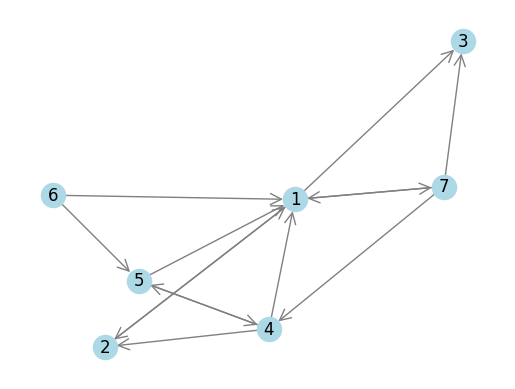

In [7]:
show_graph(edges_rdd)

In [8]:
def preparing_message(nodes_rdd, edges_rdd, echo:bool = False):
  # tuple: (node, number of out edges)
  out_edges_per_node = edges_rdd.map(lambda x: (x[0], 1)) \
                                .reduceByKey(lambda x, y: x + y)

  out_rank_per_node = nodes_rdd.join(out_edges_per_node)\
                      .mapValues(lambda x: x[0] / x[1])

  # node out, (node in, rank points)
  sum_per_node = edges_rdd.join(out_rank_per_node)

  if echo:
    for element in sorted(sum_per_node.collect()):
      print(element)

  return sum_per_node.map(lambda row: row[1])

In [9]:
# (nodo salida, (nodo entrada, valor mensaje))
message_rdd = preparing_message(nodes_rdd, edges_rdd, echo=True)

(1, (2, 0.047619047619047616))
(1, (3, 0.047619047619047616))
(1, (7, 0.047619047619047616))
(2, (1, 0.14285714285714285))
(4, (1, 0.047619047619047616))
(4, (2, 0.047619047619047616))
(4, (5, 0.047619047619047616))
(5, (1, 0.07142857142857142))
(5, (4, 0.07142857142857142))
(6, (1, 0.07142857142857142))
(6, (5, 0.07142857142857142))
(7, (1, 0.047619047619047616))
(7, (3, 0.047619047619047616))
(7, (4, 0.047619047619047616))


### **Parte 2**
Escribe una función que se haga cargo del intercambio de mensajes entre nodos. Esta función envía los mensajes a los nodos correspondientes y se hace cargo del merge de los mensajes recibidos por cada nodo. Debe retornar un RDD que para cada nodo diga cuál es el mensaje final recibido.

En el caso de que ninguna arista apunte a un nodo, el mensaje que recibe debiese ser `None`, pero por comodidad se usa 0

In [10]:
def send_messages(nodes_rdd, message_rdd, echo:bool = False):
  nodes_rank_in = message_rdd.reduceByKey(lambda x, y: x + y)

  all_nodes_rank_in = nodes_rdd.leftOuterJoin(nodes_rank_in)\
                              .map(lambda row: (row[0], row[1][1] if row[1][1] is not None else 0))

  if echo:
    for element in all_nodes_rank_in.sortByKey().collect():
      print(element)

  return all_nodes_rank_in

rank_in_per_node = send_messages(nodes_rdd, message_rdd, echo=True)

(1, 0.38095238095238093)
(2, 0.09523809523809523)
(3, 0.09523809523809523)
(4, 0.11904761904761904)
(5, 0.11904761904761904)
(6, 0)
(7, 0.047619047619047616)


### **Parte 3**
Haz una función que actualice el valor de Page Rank para cada nodo considerando el damping factor. Probablemente quieras hacer una función que tome el output del punto anterior y lo procese

Manejamos que el damping_factor sea un número entre [0,1).

In [11]:
def update_pagerank(mesagge_recived, damping_factor:float = 0, echo:bool = False, fast=True):

  if not 0 <= damping_factor < 1:
    raise ValueError("damping_factor must be between [0, 1)")


  n_nodes = mesagge_recived.count()
  damping_factor = 1 - damping_factor

  if fast:
    damping = lambda value:  (1 + value) * damping_factor / n_nodes
  else:
    damping = lambda value: Fraction( (1 + value) * damping_factor, n_nodes )

  nodes_new_rank = mesagge_recived.map(lambda row: (row[0], damping(row[1])))

  if echo:
    for element in nodes_new_rank.sortByKey().collect():
      print(element)

  return nodes_new_rank

In [12]:
nodes_updated = update_pagerank(rank_in_per_node, damping_factor=(1/8), echo=True)

(1, 0.17261904761904762)
(2, 0.13690476190476192)
(3, 0.13690476190476192)
(4, 0.13988095238095238)
(5, 0.13988095238095238)
(6, 0.125)
(7, 0.13095238095238096)


In [13]:
sum = 0
for x in nodes_updated.collect():
  sum += x[1]

print(sum)

0.9821428571428572


### **Parte 4**
Itera los pasos correspondientes por un número máximo de iteraciones, o hasta que la diferencia entre dos iteraciones del valor de Page Rank sea mínima. El programa debe retornar cada nodo junto a su valor final de Page Rank.

In [14]:
ITERATION = 3
N = 100_000
damping_factor = 0

nodes = build_page_rank_nodes(N)
edges = build_random_edges(N, 976_542)

for i in range(ITERATION):
  print(f"Iteración {i}:")
  # Preparamos los mensajes que cada nodo va a enviar
  messages_rdd = preparing_message(nodes, edges)

  # Enviamos los mensajes y obtenemos los mensajes recibidos por cada nodo
  received_messages = send_messages(nodes, messages_rdd)

  # Actualizamos los valores de Page Rank para cada nodo considerando el damping factor
  new_nodes = update_pagerank(received_messages, damping_factor)

  # Calculamos la diferencia entre los valores de Page Rank en las iteraciones
  diff = nodes.join(new_nodes)\
              .map(lambda row: abs(row[1][0] - row[1][1]))\
              .reduce(lambda x, y: x + y)

  # Imprimimos la diferencia en la iteración actual
  print(f"Diferencia en la iteración {i}: {diff}")

  # Comprobamos si la diferencia es mínima (por ejemplo, menor que 1e-9)
  if diff < 1e-9:
    print("Convergencia")
    break

  # Paso a la siguiente iteración
  nodes = new_nodes



Iteración 0:
Diferencia en la iteración 0: 9.999499999917633e-06
Iteración 1:
Diferencia en la iteración 1: 9.998950679174429e-11
Convergencia


In [ ]:
show_graph(edges)

In [15]:
# Imprimimos los valores finales de Page Rank para cada nodo
for node, page_rank in nodes.sortByKey().collect():
  print(f"Nodo {node}: Page Rank {page_rank}")

Se han truncado las últimas 5000 líneas del flujo de salida.
Nodo 95001: Page Rank 1.0000090384199134e-05
Nodo 95002: Page Rank 1.0000058737373739e-05
Nodo 95003: Page Rank 1.0000094624125874e-05
Nodo 95004: Page Rank 1.0000083181818183e-05
Nodo 95005: Page Rank 1.0000105604963663e-05
Nodo 95006: Page Rank 1.0000167183649685e-05
Nodo 95007: Page Rank 1.0000081505439004e-05
Nodo 95008: Page Rank 1.0000103174603175e-05
Nodo 95009: Page Rank 1.0000058733766232e-05
Nodo 95010: Page Rank 1.0000095453851702e-05
Nodo 95011: Page Rank 1.0000111323578383e-05
Nodo 95012: Page Rank 1.0000138506118066e-05
Nodo 95013: Page Rank 1.0000107692307692e-05
Nodo 95014: Page Rank 1.0000129664918416e-05
Nodo 95015: Page Rank 1.000005162087912e-05
Nodo 95016: Page Rank 1.000010685037185e-05
Nodo 95017: Page Rank 1.0000104478021979e-05
Nodo 95018: Page Rank 1.0000113019105077e-05
Nodo 95019: Page Rank 1.0000086624486624e-05
Nodo 95020: Page Rank 1.0000131356421355e-05
Nodo 95021: Page Rank 1.0000060037185036e